# "A simple neural network to predict galaxy rotation curves from photometry"
> "Designing a simple feedforward neural network, made with just linear layers, activations, and batch normalization, to predict rotation curves from galaxy surface brightness profiles. Comparison to the MOND empirical law."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Lorenzo Posti
- categories: [neural_network, jupyter]

## Predicting rotation curves just from photometric observations

[to be added] Motivation of the work

### The SPARC dataset

I use the rich rotation curve catalog called [SPARC](http://astroweb.cwru.edu/SPARC/), which was originally compiled by [Lelli et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016AJ....152..157L) and it is perfectly suited for this kind of study.

In [1]:
#collapse-hide
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch, math
import torch.nn as nn
from torch import tensor

%matplotlib inline
%config Completer.use_jedi = False

rng = np.random.default_rng()

Here I copied the table describing the sample and the table with all the velocity profiles and surface brightnesses.

In [2]:
# mastertable
df_sp_master = pd.read_csv('sparc_mastertable.txt', delim_whitespace=True, header=None,
                           names=['Galaxy','T','D','e_D','f_D','Inc','e_Inc','L[3.6]','e_L[3.6]','Reff','SBeff',
                                  'Rdisk','SBdisk0','MHI','RHI','Vflat','e_Vflat','Q','Ref.'])

# profiles table
df_sp_mm = pd.read_csv('sparc_mmtab.txt', delim_whitespace=True)

The SPARC database provides `Vgas`, `Vdisk`, and `Vbul` for each radius `R`, which are the contribution of respectively the gas, disk stellar component, and bulge stellar component to the total circular velocity curve of the galaxy. This are obtained directly from observations of the gas/disk/bulge surface density profiles through Poisson's equation (see [Casertano 1983](https://ui.adsabs.harvard.edu/abs/1983MNRAS.203..735C)).

From the contributions to the circular velocities of the various components, we can obtain the *total baryonic circular velocity* which is

\begin{equation}
V_{\rm bar}^2 = V_{\rm gas}^2 + (M/L)_{\rm disk}V_{\rm disk}^2 + (M/L)_{\rm bul}V_{\rm bul}^2,
\end{equation}

where we set $(M/L)_{\rm disk}=0.5$ and $(M/L)_{\rm bul}=0.7$ (at 3.6$\mu$m) as suggested by [Lelli et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...816L..14L).

In [3]:
df_sp_mm['Vbar'] = np.sqrt(df_sp_mm['Vgas']**2+0.5*df_sp_mm['Vdisk']**2+0.7*df_sp_mm['Vbul']**2)

### An appropriate baseline model: MOND

The best way that we have to predict rotation curves from surface density profiles is by using the empirical MOND law. Modified Newtonian Dynamics (MOND) was introduced by [Milgrom (1983)](https://ui.adsabs.harvard.edu/abs/1983ApJ...270..365M/) and it consists of a modification of Newtonian gravity which is empirically observed to fit galaxy rotation curves without the need for dark matter.

While MOND has been developed to be a full gravitational theory, here I am going to use the phenomenological law of gravity relevant for galaxy disks (see e.g. Eq. 3 [here](http://www.scholarpedia.org/article/The_MOND_paradigm_of_modified_dynamics)). The acceleration in MOND is related to the Newtonian acceleration as:
$$
g_{\rm MOND} = g_{\rm N}\nu(g_{\rm N}/a_0), \qquad {\rm or} \qquad g_{\rm N} = g_{\rm MOND}\mu(g_{\rm MOND}/a_0),
$$
where $g_{\rm N}$ is the Newtonian acceleration, $a_0$ is a constant acceleration and $\nu$ is the so-called *interpolating function* that specifies the MOND theory. Here I am using
$$
\nu(y) = \frac{1+(1+4y^{-1})^{1/2}}{2},
$$
whose inverse is $\mu(x)=x/(1+x)$, i.e. the so-called *simple interpolating function* in MOND jargon ([Famaey & Binney 2005](https://ui.adsabs.harvard.edu/abs/2005MNRAS.363..603F), [Famaey & McGaugh 2012](https://ui.adsabs.harvard.edu/abs/2012LRR....15...10F)), and a constant acceleration scale $a_0 = 1.2\times 10^{-10} \rm m\,s^{-2}$ (see e.g. [McGaugh et al. 2016](https://ui.adsabs.harvard.edu/abs/2016PhRvL.117t1101M)).

The acceleration due to baryons alone is just $g_{\rm bar} = V_{\rm bar}^2/R$. 
Then, since $V_{\rm MOND} = \sqrt{g_{\rm MOND}R}$ and $g_{\rm MOND} = g_{\rm bar}\nu(g_{\rm bar}/a_0)$, I finally get that
$$
V_{\rm MOND} = \sqrt{R\,g_{\rm bar}\nu(g_{\rm bar}/a_0)}=V_{\rm bar}\sqrt{\nu(g_{\rm bar}/a_0)}
$$

In [4]:
df_sp_mm['Gbar'] = df_sp_mm['Vbar']**2 / (df_sp_mm['R']*3.086e16) * 1e3 # m s^-2

# interpolating nu-function (Eq. 3, http://www.scholarpedia.org/article/The_MOND_paradigm_of_modified_dynamics)
# corresponding to the "simple" mu-function of Famaey & Binney
nu_mond = lambda y: 0.5+0.5*np.sqrt(1+4/y)

df_sp_mm['Vmond'] = df_sp_mm['Vbar'] * np.sqrt(nu_mond(df_sp_mm['Gbar']/1.2e-10))

Now we have a baseline model that we can use as an expectation on the rotation curve of a disk galaxy from its surface brightness

## A neural network model

We now want to set up a deep neural network (NN) architecture that gets as an input arrays of $R$ and $V_{\rm bar}(R)$ and outputs arrays of the total circular velocity of a disk galaxy, $V_{\rm obs}(R)$.

### Data manipulation

Let's start by splitting the sample into training and validation sets. There are 175 galaxies in SPARC, each with a rotation curve array with variable size. Let's split the catalog in 145 random galaxies for training and 30 random galaxis for validation, even though they will have very different numbers of curve datapoints.

In [6]:
# using rng.choice to generate random integers without repetitions
valid_gals = rng.choice(174, size=30, replace=False) # 30/175 = 17% of galaxies in validation set
train_idx = np.where(~np.isin(df_sp_mm.Galaxy, df_sp_master['Galaxy'][valid_gals]))[0]
valid_idx = np.where(np.isin(df_sp_mm.Galaxy, df_sp_master['Galaxy'][valid_gals]))[0]

# shuffle training dataset
rng.shuffle(train_idx)

splits = (list(train_idx), list(valid_idx))

Then I normalize the $X=[R, V_{\rm bar}]$ and $Y=[V_{\rm obs}]$ arrays, i.e. the input and output of the NN, and I convert them to tensors.

In [7]:
df_nn = df_sp_mm[['R', 'Vbar']] # columns used in the NN
df_nn_train, df_nn_valid = df_nn.iloc[train_idx], df_nn.iloc[valid_idx]
y_nn_train, y_nn_valid = df_sp_mm['Vobs'].iloc[train_idx], df_sp_mm['Vobs'].iloc[valid_idx]

# normalize X
mean_df_nn, std_df_nn = df_nn_train.mean(), df_nn_train.std()
df_nn_train_norm = (df_nn_train-mean_df_nn)/std_df_nn
df_nn_valid_norm = (df_nn_valid-mean_df_nn)/std_df_nn
# normalize y
mean_y_nn, std_y_nn = y_nn_train.mean(), y_nn_train.std()
y_nn_train_norm = (y_nn_train-mean_y_nn)/std_y_nn
y_nn_valid_norm = (y_nn_valid-mean_y_nn)/std_y_nn

# convert to tensors
x_train = tensor(df_nn_train_norm.values).float()
y_train = tensor(y_nn_train_norm.values).float()
x_valid = tensor(df_nn_valid_norm.values).float()
y_valid = tensor(y_nn_valid_norm.values).float()

Normalize and tensorize also the MOND predictions, so that we will be able to compare the losses with the NN model.

In [86]:
ymond_train = tensor(((df_sp_mm['Vmond'].iloc[train_idx]-mean_y_nn)/std_y_nn).values).float()
ymond_valid = tensor(((df_sp_mm['Vmond'].iloc[valid_idx]-mean_y_nn)/std_y_nn).values).float()

#### Minimal `Dataset` and `Dataloader`

I bundle the training and validation sets into a simple dataset class derived from `torch.utils.data.Dataset`. This is meant to be used with `torch.utils.data.DataLoader` for batch training.

Defining the datasets

In [9]:
class RotCurveDset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self): return len(self.x)
        
    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    
dset_train = RotCurveDset(x_train, y_train)
dset_valid = RotCurveDset(x_valid, y_valid)

and defining the dataloaders, with a rather large batch size (640) compared to the total number of the training datapoints (~2700)

In [79]:
bs = 64*10
dload_train = torch.utils.data.DataLoader(dset_train, batch_size=bs)
dload_valid = torch.utils.data.DataLoader(dset_valid, batch_size=bs)

### The `torch.nn` model

I set up an extremely simple architecture with just one hidden layer, with 64 units, a leaky ReLU activation, and a BatchNorm layer.

In [11]:
nl1 = 64
model = nn.Sequential(nn.Linear(2, nl1), nn.LeakyReLU(), nn.BatchNorm1d(nl1),
#                       nn.Linear(nl1, nl1), nn.LeakyReLU(), #nn.Dropout1d(p=0.6),
                      nn.Linear(nl1, 1))
model

I use a standard mean squared error loss function and the Adam optimizer algorithm, with a moderate weight decay to prevent overfitting.

In [ ]:
loss_fn = nn.MSELoss(reduction='mean')
optim   = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

### Training loop

We now train the model. At each epoch we store the training loss and validation loss and after 1000 epochs we compare the training losses and validation losses to the MOND case.

In [12]:
%%time
epochs = 1000

train_losses, valid_losses = [], []
for i in range(epochs):

    #
    # train phase
    #
    model.train()
    for batch, (x,y) in enumerate(dload_train):
        # model and loss
        y_pred = model(x)
        loss = loss_fn(y_pred.squeeze(), y)
        
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    #
    # test phase
    #
    model.eval()
    with torch.no_grad():
        loss = loss_fn(model(x_train).squeeze(), y_train)
        val_loss = loss_fn(model(x_valid).squeeze(), y_valid)
        train_losses.append(loss)
        valid_losses.append(val_loss)
    if i % 100 == 0: print ("Epoch: %2d   [Train Loss: %1.5f  //  Valid Loss: %1.5f]" % (i, loss, val_loss))
        
print ()
print ('---------------------')
print ('Comparison with MOND:  [Train Loss: %1.5f  //  Valid Loss: %1.5f]' % (loss_fn(ymond_train, y_train),
                                                                              loss_fn(ymond_valid, y_valid)))
print ('---------------------')
print ()

Epoch:  0   [Train Loss: 1.05912  //  Valid Loss: 1.13404]
Epoch: 100   [Train Loss: 0.09393  //  Valid Loss: 0.07471]
Epoch: 200   [Train Loss: 0.07501  //  Valid Loss: 0.05540]
Epoch: 300   [Train Loss: 0.07064  //  Valid Loss: 0.05421]
Epoch: 400   [Train Loss: 0.06949  //  Valid Loss: 0.05205]
Epoch: 500   [Train Loss: 0.06878  //  Valid Loss: 0.05173]
Epoch: 600   [Train Loss: 0.06816  //  Valid Loss: 0.05136]
Epoch: 700   [Train Loss: 0.06742  //  Valid Loss: 0.05121]
Epoch: 800   [Train Loss: 0.06701  //  Valid Loss: 0.05139]
Epoch: 900   [Train Loss: 0.06668  //  Valid Loss: 0.05140]

---------------------
Comparison with MOND:  [Train Loss: 0.07238  //  Valid Loss: 0.04494]
---------------------

CPU times: user 54 s, sys: 1.24 s, total: 55.3 s
Wall time: 42 s


We can see that while the NN model is able to have a training loss significantly smaller than the MOND case, the validation loss is similar or even smaller in the MOND case. This exemplifies the difficulty in generalizing the behaviour learned in the training phase.

Let's now look at the plot of the training and validation losses as a function of epoch.

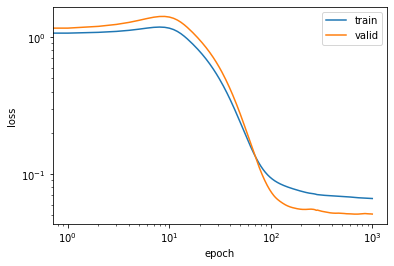

In [88]:
plt.loglog(train_losses, label='train')
plt.loglog(valid_losses, label='valid')
plt.legend();
plt.xlabel('epoch')
plt.ylabel('loss');

Here we can see that for this particular train/valid split, the learning rate and the weight decay hyper-parameters, as well as the number of units and linear layers of the NN, are well tuned to have gradually decreasing train and validation losses. Increasing the model's complexity or adding additional layers (e.g. Dropout) does not seem to help in this case, thus I preferred to stick with a simple 1-layer feedforward NN.

### Comparing rotation curve predictions

Now that we have trained the NN model, we can apply it to the validation set in order to make proper predictions for the rotation curves of disk galaxies just from their surface density profile.

In [99]:
y_pred = model(x_valid).squeeze(-1).detach()

And finally we can plot the rotation curves of the 30 galaxies in the validation set in separate panels. Below I overplot the real data (black points), the MOND empirical expectation (blue dotted curve), and the NN prediction (orange solid curve)

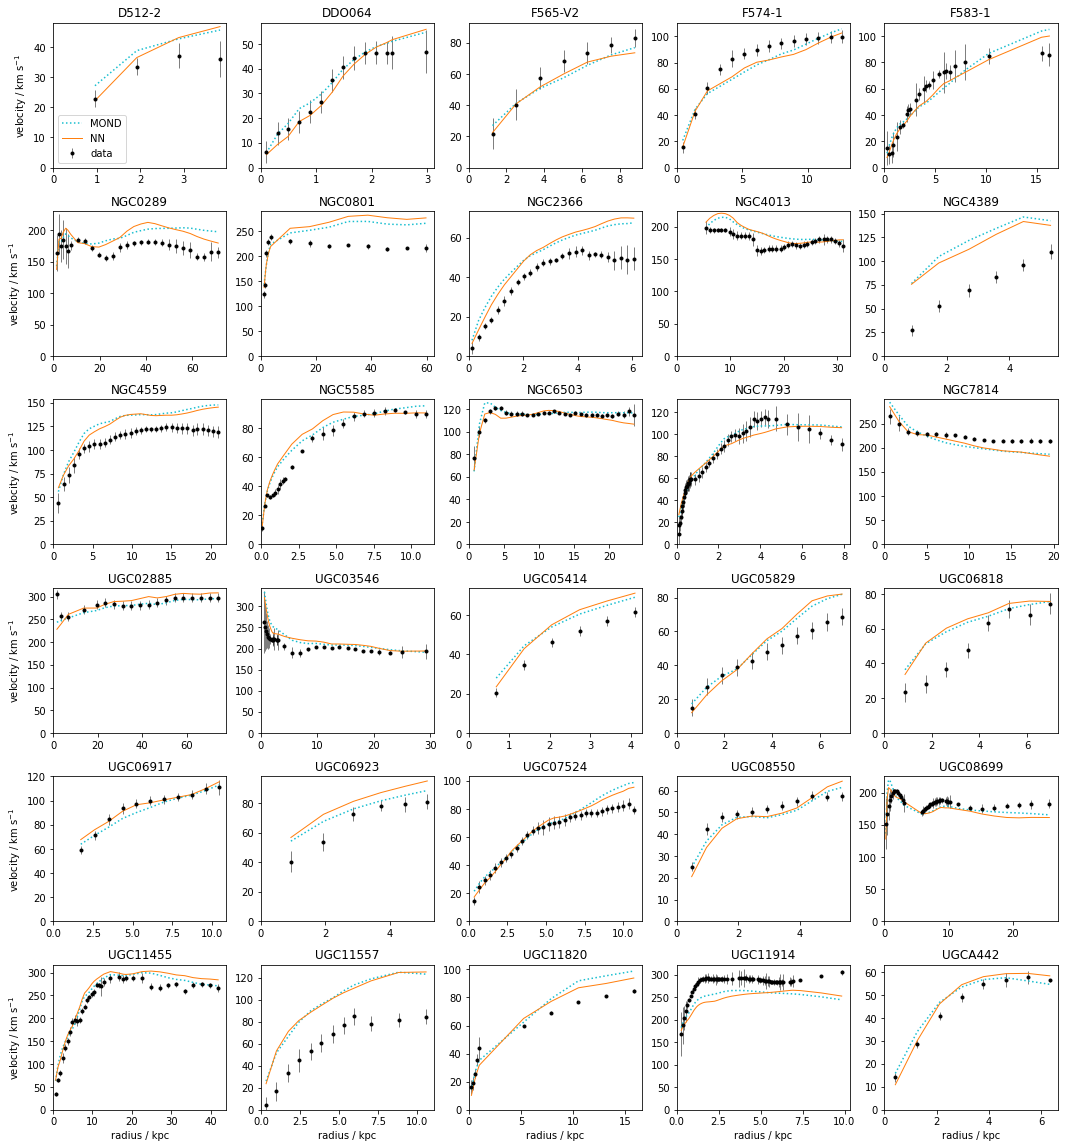

In [108]:
fig, ax = plt.subplots(figsize=(18,20), ncols=5, nrows=6, gridspec_kw={'hspace':0.3})

for k,g in enumerate(df_sp_mm['Galaxy'].iloc[valid_idx].unique()):
    
    i,j = int(k/5), k%5

    ax[i,j].errorbar(df_sp_mm['R'][df_sp_mm['Galaxy']==g], df_sp_mm['Vobs'][df_sp_mm['Galaxy']==g], 
                     yerr=df_sp_mm['e_Vobs'][df_sp_mm['Galaxy']==g], c='k', fmt='.', lw=0.5, label='data')
    ax[i,j].plot(df_sp_mm['R'][df_sp_mm['Galaxy']==g], df_sp_mm['Vmond'][df_sp_mm['Galaxy']==g], c='C9', 
                 ls=':', label='MOND')
    ax[i,j].plot(df_sp_mm['R'][df_sp_mm['Galaxy']==g], 
                 std_y_nn*y_pred[(df_sp_mm['Galaxy'].iloc[valid_idx]==g).values] + mean_y_nn, c='C1',
                 lw=1, label='NN')
    ax[i,j].set_xlim((0,None))
    ax[i,j].set_ylim((0,None))
    ax[i,j].set_title(g)
    if i==5: ax[i,j].set_xlabel('radius / kpc');
    if j==0: ax[i,j].set_ylabel('velocity / km s'+'$^{-1}$');
ax[0,0].legend();

All in all, the performance of the NN model are quite satisfactory as it gives nice predictions for $V_{\rm obs}$ for the majority, though not all, galaxies.

Strikingly, **the predictions of the NN model are extremely close to the MOND rotation curves!** This means that a flexible NN when asked to predict rotation curves from surface densities reduces to something that closely resemble the MOND phenomenology. This suggests that, at least in the SPARC dataset, there is nothing more to learn on the rotation curve shapes that is not encapsulated in the MOND empirical law.

To see this even better, let's plot the baryonic acceleration versus the total gravitational acceleration oberved/predicted in the rotation curves. This is the so-called *radial acceleration relation* plot [(McGaugh et al. 2016)](https://ui.adsabs.harvard.edu/abs/2016PhRvL.117t1101M).

The MOND prediction is pretty clear on this diagram, as $g_{\rm MOND} = g_{\rm bar} \nu(g_{\rm bar}/a_0)$.
On the other hand, to generate this for the NN model I take a toy rotation curve that is flat at 200 km/s and that spans a huge radial radial extension, from 0.1 kpc to 1 Mpc. This is done just to cover smoothly both the low- and high-acceleration regimes in which the SPARC galaxies are found.

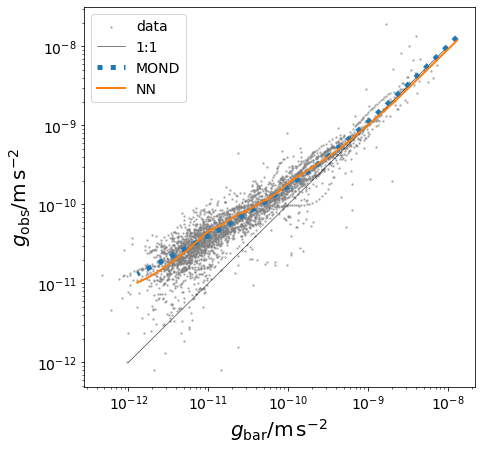

In [126]:
def gmond(vbar, r): return (vbar**2 * nu_mond(vbar**2/(r*3.086e16)*1e3/1.2e-10)) / (r*3.086e16)*1e3
def get_normed_rv_tensor(r, v):
    return ((torch.vstack((tensor(r),tensor(v))).T - tensor(mean_df_nn.values))/tensor(std_df_nn.values)).float()

r = np.logspace(-1., 3., 200)
v = np.full_like(_r, 200.)
vmod = (model(get_normed_rv_tensor(r, v)).squeeze(-1).detach()*std_y_nn+mean_y_nn).numpy()


fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(df_sp_mm['Gbar'], df_sp_mm['Vobs']**2 / (df_sp_mm['R']*3.086e16) * 1e3, s=2, 
           c='grey', alpha=0.5, label='data')
ax.loglog([1e-12,1e-8],[1e-12,1e-8], 'k-', lw=0.5, label='1:1')
ax.loglog(v**2/(r*3.086e16)*1e3, gmond(v, r), ':', c='C0', lw=5, label='MOND')
ax.loglog(v**2/(r*3.086e16)*1e3, vmod**2/(r*3.086e16)*1e3, '-', c='C1', lw=2, label='NN')
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_xlabel(r"$g_{\rm bar}/\rm m\,s^{-2}$", fontsize=20);
ax.set_ylabel(r"$g_{\rm obs}/\rm m\,s^{-2}$", fontsize=20);

There is clearly a very good agreement between both models and the data and between the NN and MOND models themselves. Both the data and the two models follow a smooth departure from the 1:1 line at around the charcteristic acceleration scale $a_0=1.2\times 10^{-10}\rm m\,s^{-2}$.

The fact that the flexible NN model follows closely the MOND expectations in this diagram is, again, suggesting that the full SPARC dataset can be very well described with just the MOND empirical law plus some scatter.